# A.2. Solutions

## Fixed Income Module

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu


### Instructions

#### Work on this in your group.
#### Don't spend more than 45 minutes on it during the 12-2pm break. (We want you to have time refresh and eat.)
#### We encourage you to do more on the problems in the afternoon/evening if able and interested.

# Data

This assignment uses the data file `../data/treasury_quotes_2022-03-31.xlsx`.

# 1. Treasury Debt Composition

## Note

The `ITYPE` column identifies
* 1: bonds
* 2: notes
* 4: bills
* 11: TIPS notes
* 12: TIPS bonds

The column `TDPUBOUT` lists the dollar size of the issue (public debt outstanding.)

The data source does not list the issue size for the T-bills, which is why we are not segmenting those out separately.

*Tip* `.pivot_table()` may be useful.

## 1.1
Plot the total amount of outstanding debt maturing at each date

## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS (combined ITYPE of 11 and 12.)

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

## 1.4
Make a pie chart of this total number (reported in 1.3.) 

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
QUOTE_DATE = '2022-03-31'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In addition to `TDPUBOUT` for total public debt outstanding, 

also try `TDTOTOUT` for total debt outstanding, which also reports bills.

The variable `KEY` below selects which variable is examined.

In [4]:
KEY = 'TDTOTOUT'

## 1.1

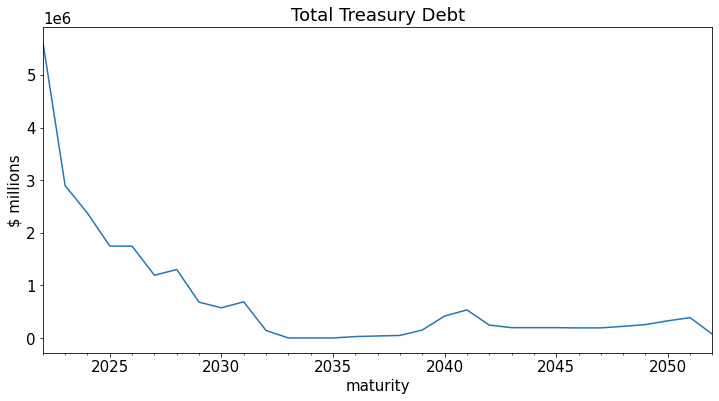

In [5]:
debts = rawdata.pivot_table(values=KEY,index='TMATDT',columns='ITYPE',aggfunc='sum') \
    .resample('Y').sum().rename(columns={1:'bonds',2:'notes',4:'bills'})
debts['TIPS'] = debts[11] + debts[12]
debts.drop(columns=[11,12],inplace=True)

debts.sum(axis=1).plot(title='Total Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.2

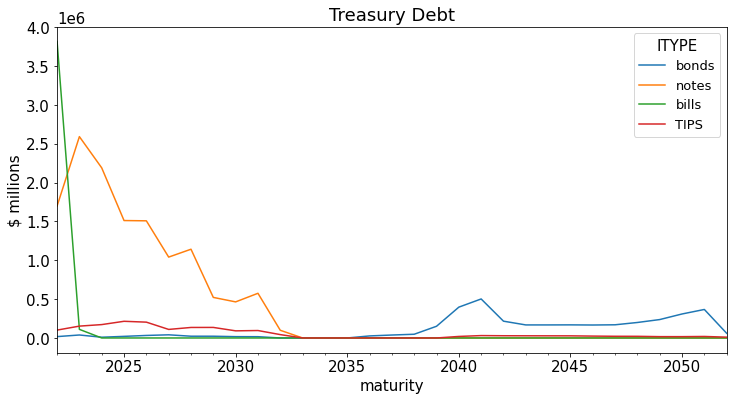

In [6]:
debts.plot(title='Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.3

In [7]:
debts.sum().to_frame().rename(columns={0:'debt outstanding ($ millions)'}).style.format('{:,.2f}')

,debt outstanding ($ millions)
ITYPE,
bonds,"3,631,481.00"
notes,"13,348,436.00"
bills,"3,928,964.00"
TIPS,"1,751,948.00"


## 1.4

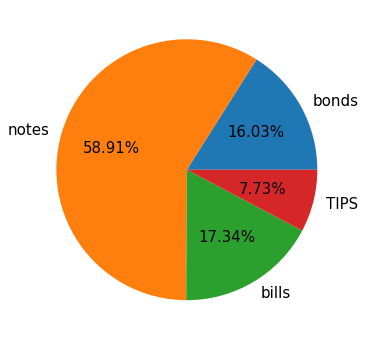

In [8]:
plt.pie(debts.sum().values, labels=debts.columns, autopct='%1.2f%%')
plt.show()

### Not requested, but perhaps interesting to see outstanding via issue

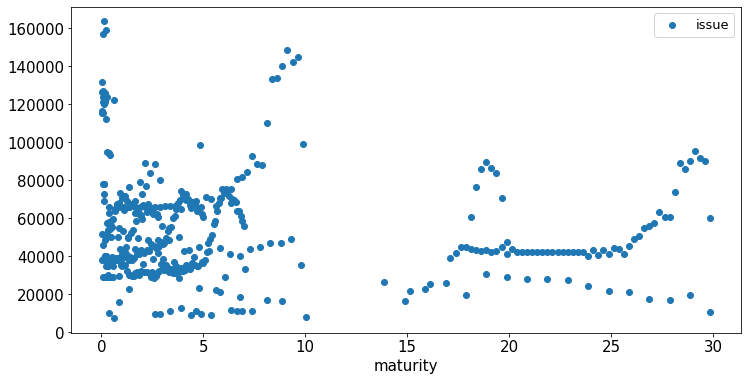

In [9]:
mats = get_maturity_delta(rawdata[['TMATDT']].astype('datetime64[ns]'), t_current=t_current).rename(columns={'TMATDT':'maturity'})

plt.scatter(mats,rawdata[KEY]);
plt.legend(['issue']);
plt.xlabel('maturity');

# 2 Bond Metrics

## 2.1

Calculate the time-to-maturity (relative to the quote date of 2022-03-31) for each issue.

Use the `TMATDT` column to get the maturity date.

Report the summary statistics of these time-to-maturities. (Consider using .describe()).

## 2.2
Plot the time-to-maturity against the provided YTM, (column `TDYLD`.)

## 2.3

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `ITYPE`=4 or looking for `TCOUPRT` of 0.

## 2.4 Extra

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

# <span style="color:red">Solution 2</span>

## 2.1

In [10]:
mats_issues = get_maturity_delta(rawdata['TMATDT'],t_current=t_current)
mats_issues.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
TMATDT,423.0,6.535645,8.178633,0.013689,1.019849,3.167693,6.859685,29.878166


## 2.2

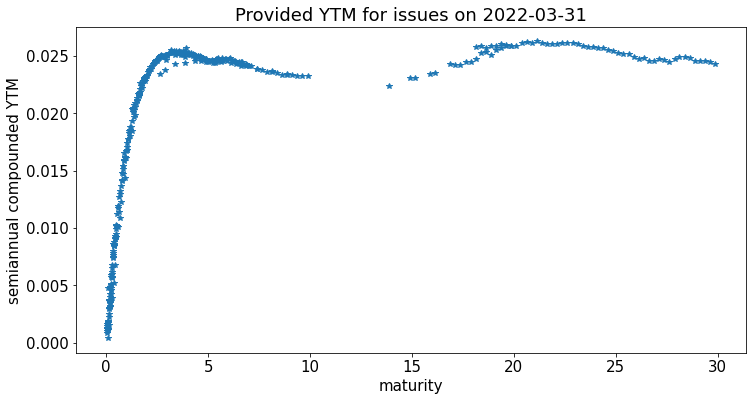

In [11]:
FREQ = 365

plt.plot(mats_issues,rawdata['TDYLD']* FREQ,linestyle='',marker='*')
plt.title(f'Provided YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

## 2.3

In [12]:
DAYCT_ADJ = 360/365

tbills = rawdata[rawdata['ITYPE']==4]
px_tbills = tbills[['TDASK','TDBID']].mean(axis=1)
mat_bills = get_maturity_delta(tbills['TMATDT'],t_current=t_current)
disc_yield = ((100-px_tbills)/100 / (mat_bills * DAYCT_ADJ)).to_frame().rename(columns={0:'discount yield'})
disc_yield.style.format('{:.2%}')

,discount yield
KYTREASNO,
207809,0.13%
207772,0.14%
207810,0.10%
207784,0.09%
207811,0.12%
207699,0.13%
207812,0.16%
207785,0.11%
207813,0.04%


In [13]:
disc_yield.describe().T.style.format('{:.2%}')

,count,mean,std,min,25%,50%,75%,max
discount yield,5100.00%,0.59%,0.40%,0.04%,0.24%,0.51%,0.88%,1.62%


## 2.4

We will get a better YTM estimate if we use a price that is...
* the mean of the **bid** (`TDBID`) and **ask** (`TDASK`)
* includes the **accrued interest** (`TDACCINT`)

In [14]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [15]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [16]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.Series(index=px.index,dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

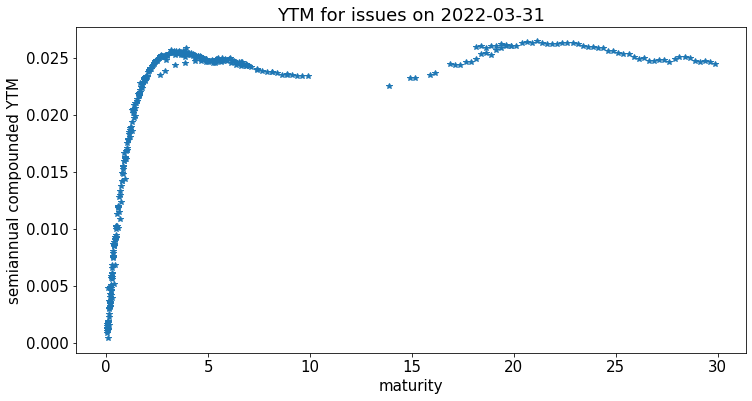

In [17]:
plt.plot(mats_issues.loc[ytm.index],ytm,linestyle='',marker='*')
plt.title(f'YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

### Compare to the provided YTM calcs in the original data source

In [18]:
(rawdata['TDYLD'].loc[CF.index]*FREQ - ytm).describe().to_frame().rename(columns={0:'yield error'}).T.style.format('{:,.4%}')

,count,mean,std,min,25%,50%,75%,max
yield error,"37,400.0000%",-0.0126%,0.0065%,-0.0191%,-0.0173%,-0.0163%,-0.0075%,-0.0000%


# 3 Extra: Bootstrapping the Spot Curve

## 3.1 
Set up the cashflow matrix.
* Consider using the function `calc_cashflows()` provided in the module `../cmds/treasury_cmds.py`.
* Or even better, build a function yourself, accounting for semiannual coupons, the coupon rate, and the maturity date.

You should end up with a matrix where each 
* row is a treasury issue
* column is a payment date

Report the first and last 5 rows of the cashflow matrix. (Simply `display` the dataframe.)

## 3.2
Filter the treasury issues such that you have only those with
* maturity is within 5 years of the quote date
* there are no issues with negative imputed YTM 

## 3.3
Additionally, filter for identification.
1. Eliminate any columns from the cashflow matrix that do not pay principal for some issue. (i.e. Columns where no cashflow is at least 100.) 
2. Eliminate any issue that paid a coupon on one of the eliminated dates.

How many rows and columns is the filtered cashflow matrix?

Report the first and last 5 rows of the filtered cashflow matrix. (Simply `display` the dataframe.)

## 3.4
Run an OLS estimation of issues prices on the cashflow matrix to extract the discount rates.

Plot the discount rates.

Plot the associated spot rate curve (continuously compounded)

# <span style="color:red">Solution 3</span>

## 3.1

If you did 2.4, then you already have the cashflow matrix.

For now, the only issues we filter out are the TIPS.

In [19]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [20]:
display(CF)

,2022-04-05,2022-04-07,2022-04-12,2022-04-14,2022-04-15,2022-04-19,2022-04-21,2022-04-26,2022-04-28,2022-04-30,...,2049-11-15,2050-02-15,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207809,100,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
207772,0,100,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
207810,0,0,100,0,0.000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
207784,0,0,0,100,0.000,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
207347,0,0,0,0,101.125,0,0,0,0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207680,0,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.000,0.0000,0.000
207719,0,0,0,0,0.000,0,0,0,0,0.0,...,1.1875,0.0000,1.1875,0.0000,1.1875,0.0000,101.1875,0.000,0.0000,0.000
207763,0,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,101.000,0.0000,0.000


In [21]:
idx = rawdata['TMATDT']<'2025-01-01'
data = rawdata[idx]
#data = rawdata
idx = data['TDYLD'].notna()
data = data[idx]
idx = data['ITYPE']<5
data = data[idx]
#CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
#CF
data

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207809,20220405.400000,2022-03-31,99.998194,99.998333,99.998264,M,I,0.000000,-6.944560e-07,0.000003,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207772,20220407.400000,2022-03-31,99.997181,99.997375,99.997278,M,I,0.000000,-6.111240e-06,0.000004,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207810,20220412.400000,2022-03-31,99.996500,99.996833,99.996667,M,I,0.000000,1.722309e-05,0.000003,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207784,20220414.400000,2022-03-31,99.996500,99.996889,99.996694,M,I,0.000000,2.319575e-05,0.000002,...,NaN,0,NaN,4,0,1,1,NaN,NaN,NaN
207347,20220415.202250,2022-03-31,100.070312,100.101562,100.085938,M,I,1.032280,-5.475896e-05,0.000004,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207444,20241130.201500,2022-03-31,97.359375,97.390625,97.375000,M,I,0.498626,3.615240e-04,0.000069,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
207157,20241130.202120,2022-03-31,98.968750,99.000000,98.984375,M,I,0.706387,-8.028355e-04,0.000069,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN
207820,20241215.201000,2022-03-31,96.046875,96.070312,96.058594,M,I,0.291209,-1.792674e-03,0.000068,...,NaN,0,NaN,2,0,1,1,NaN,NaN,NaN


## 3.2 - 3.3

In [22]:
RESTRICT_YLD = True
RESTRICT_TIPS = True
RESTRICT_MAT = 5

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_maturity=RESTRICT_MAT,filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [23]:
display(CF)

,2022-04-05,2022-04-07,2022-04-12,2022-04-14,2022-04-15,2022-04-19,2022-04-21,2022-04-26,2022-04-28,2022-04-30,...,2025-08-15,2025-11-15,2026-01-31,2026-02-15,2026-05-15,2026-07-31,2026-08-15,2026-11-15,2027-01-31,2027-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207809,100,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000
207772,0,100,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000
207810,0,0,100,0,0.000,0,0,0,0,0.0,...,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000
207784,0,0,0,100,0.000,0,0,0,0,0.0,...,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000
207347,0,0,0,0,101.125,0,0,0,0,0.0,...,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207036,0,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,1.00,0.00,0.0000,1.00,0.00,0.0000,101.00,0.00,0.0000
204088,0,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,3.25,0.00,0.0000,3.25,0.00,0.0000,103.25,0.00,0.0000
207472,0,0,0,0,0.000,0,0,0,0,0.0,...,0.0000,0.00,0.75,0.0000,0.00,0.75,0.0000,0.00,100.75,0.0000


## 3.4

For best results, calculate price as midpoint of bid-ask and include accrued interest, (for "dirty" price.)

In [24]:
px_curve = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
px_curve = px_curve.loc[CF.index]

mat_CF_extract = get_maturity_delta(CF.columns,t_current=t_current)

# LinearRegression does not like columns as timestamps
# So make copy with columns as strings
CFshell = CF.copy()
CFshell.columns = CFshell.columns.astype('str')

curve_extract = pd.DataFrame(LinearRegression(fit_intercept=False).fit(CFshell,px_curve).coef_, index=CF.columns, columns=['discount factor'])

curve_extract['rate'] = discount_to_intrate(curve_extract['discount factor'], mat_CF_extract,n_compound=2)

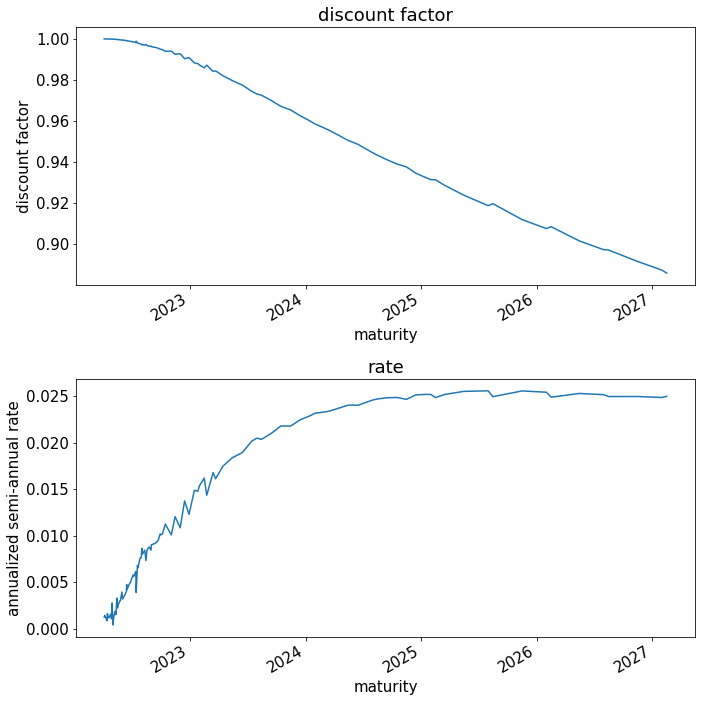

In [25]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
curve_extract['discount factor'].plot(ax=ax[0], xlabel='maturity', ylabel='discount factor', title='discount factor')
curve_extract['rate'].plot(ax=ax[1], xlabel='maturity', ylabel='annualized semi-annual rate', title='rate')
plt.tight_layout()
plt.show()